# Kings County Housing Prices Bakeoff

Below are a list of steps that you should take while trying to complete your bake-off entry.

In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
%matplotlib inline

## Step 1: Read in Data

In [194]:
house_train = pd.read_csv('data/kc_house_data_train.csv', index_col = 0)
house_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,...,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,...,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,...,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,...,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,...,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


In [195]:
house_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17290 entries, 0 to 17289
Data columns (total 21 columns):
id               17290 non-null int64
date             17290 non-null object
price            17290 non-null float64
bedrooms         17290 non-null int64
bathrooms        17290 non-null float64
sqft_living      17290 non-null int64
sqft_lot         17290 non-null int64
floors           17290 non-null float64
waterfront       17290 non-null int64
view             17290 non-null int64
condition        17290 non-null int64
grade            17290 non-null int64
sqft_above       17290 non-null int64
sqft_basement    17290 non-null int64
yr_built         17290 non-null int64
yr_renovated     17290 non-null int64
zipcode          17290 non-null int64
lat              17290 non-null float64
long             17290 non-null float64
sqft_living15    17290 non-null int64
sqft_lot15       17290 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 2.9+ MB


## Step 2: Exploratory Data Analysis 
    
Become familiar with the data.  Look to see if there are any extreme values.  

Additionally create data visualizations to determine if there are any relationships between your features and your target variables.  

In [196]:
# Change date variable to something useful. 
house_train['month'] = house_train.date.apply(lambda x: int(x[4:6]))
house_train['yr'] = house_train.date.apply(lambda x: int(x[0:4]))
house_train.date = house_train.date.apply(lambda x: int(x[0:8]))


There's a house with 30+ bedrooms. Let's take a look at that.

In [197]:
house_train[house_train.bedrooms > 20]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,yr
8597,2402100895,20140625,640000.0,33,1.75,1620,6000,1.0,0,0,...,580,1947,0,98103,47.6878,-122.331,1330,4700,6,2014


It's likely that 33 bedrooms is an error, since it's a small place with less than 2 bathrooms. We will change that value to more appropriate number.

In [198]:
round((house_train.bedrooms/house_train.sqft_living).median()*1620)
# median # of bedroom per sqft.living multiplied by sqft.living 
house_train.at[8597, 'bedrooms'] = 3

### Age 
I'll create a new measure called age.  
This will be time between the last renovation till sales date.  
Or since the date built if it has never been renovated.  

In [199]:
house_train[house_train.yr < house_train.yr_built]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,yr
117,3076500830,20141029,385195.0,1,1.00,710,6000,1.5,0,0,...,0,2015,0,98144,47.5756,-122.316,1440,4800,10,2014
6233,9126100346,20140617,350000.0,3,2.00,1380,3600,3.0,0,0,...,0,2015,0,98122,47.6074,-122.305,1480,3600,6,2014
6800,1250200495,20140624,455000.0,2,1.50,1200,1259,2.0,0,0,...,200,2015,0,98144,47.6001,-122.298,1320,1852,6,2014
7048,6058600220,20140731,230000.0,3,1.50,1040,1264,2.0,0,0,...,140,2015,0,98144,47.5951,-122.301,1350,3000,7,2014
11830,5694500840,20141125,559000.0,2,3.00,1650,960,3.0,0,0,...,300,2015,0,98103,47.6611,-122.346,1650,3000,11,2014
12766,9310300160,20140828,357000.0,5,2.50,2990,9240,2.0,0,0,...,0,2015,0,98133,47.7384,-122.348,1970,18110,8,2014
13738,9126100765,20140801,455000.0,3,1.75,1320,1014,3.0,0,0,...,0,2015,0,98122,47.6047,-122.305,1380,1495,8,2014


Actually cannot do that because it seems like 'date' doesn't mean year sold.

In [142]:
#house_train['age'] = np.where(house_train.yr_renovated == 0, house_train.yr_sold - house_train.yr_built, 
#         house_train.yr_sold - house_train.yr_renovated)

In [143]:
house_train.shape

(17290, 24)

#### Price distribution

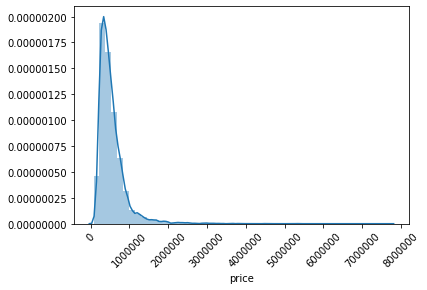

In [168]:
sns.distplot(house_train.price)
plt.xticks(rotation=45)
plt.show()

#### Log Price distribution

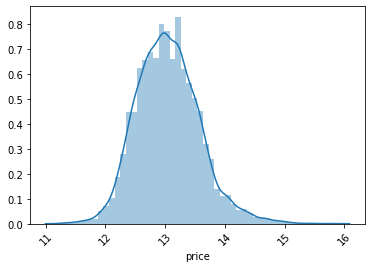

In [169]:
sns.distplot(np.log(house_train.price))
plt.xticks(rotation=45)
plt.show()

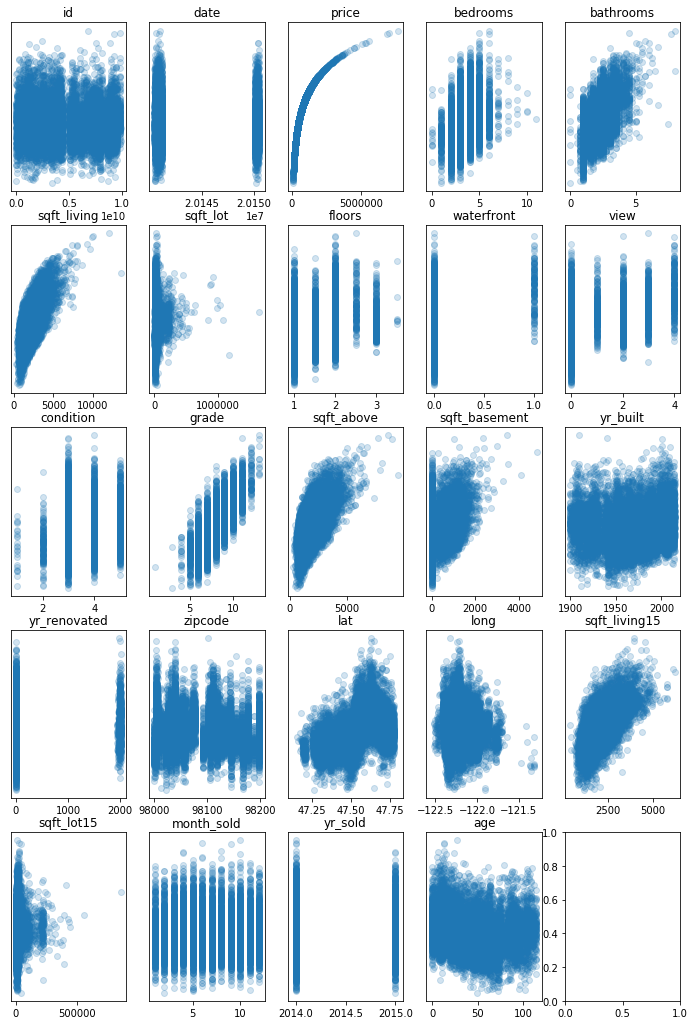

In [146]:
# for each columns, plot scatter plot
fig, axes = plt.subplots(nrows = 5, ncols = 5, figsize = (12, 18))

axes = axes.ravel() 

for i in range(len(house_train.columns)):
    axes[i].scatter(house_train.iloc[:, i], np.log(house_train.price), alpha = 0.2)
    axes[i].set_title(house_train.columns[i])
    axes[i].get_yaxis().set_ticks([])


### Observations
#### Clear correlation
1. Sqft.living, grade
(bedroom and bathroom also strongly correlates but likely covered by sqft.living)

#### Outliers to deal with
1. Bedroom - one outlier (v)

#### Further investigation needed
1. age - some negative correlation after certain price point.
2. Categorical value to look at - condition, waterfront, view


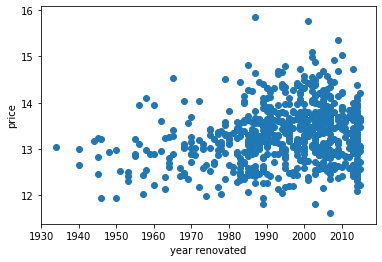

In [150]:
reno = house_train[house_train.yr_renovated != 0]
plt.scatter(reno.yr_renovated, np.log(reno.price))
plt.xlabel("year renovated")
plt.ylabel("price")
plt.show()

## Collinearity Check
Let's see if any of the variables I chose are highly correlated. 


In [209]:
variables = ['price', 'sqft_living', 'grade', 'condition', 'waterfront', 'view']
select_var = house_train[[col for col in house_train.columns if col in variables ]]


select_var.corr()


,price,sqft_living,waterfront,view,condition,grade
price,1.000000,0.703540,0.275779,0.395485,0.036099,0.666215
sqft_living,0.703540,1.000000,0.109738,0.283336,-0.061530,0.762929
waterfront,0.275779,0.109738,1.000000,0.407565,0.009608,0.092234
view,0.395485,0.283336,0.407565,1.000000,0.045060,0.249554
condition,0.036099,-0.061530,0.009608,0.045060,1.000000,-0.142066
grade,0.666215,0.762929,0.092234,0.249554,-0.142066,1.000000


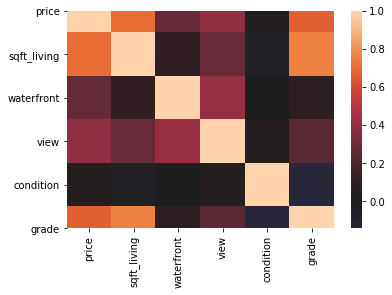

In [210]:
sns.heatmap(select_var.corr(), center=0);

Grade seems to have a pretty high correlation with sqft_living, so I'll remove that for now.

## Step 3: Clean up any issues with the data like extreme values.  

remember that you can't just delete rows with extreme values. Similar observations might be present in the holdout dataset, and you can't just delete those rows and not have a prediction for it. 

## Step 4: Generate new features that you think could be important

After doing this, you will want to go back to steps 2 and 3 to investigates these new features

Selecting features I think will work and scaling or turning into dummy as I see fit. 

In [221]:
# scaler function 

def df_transformation(df):
    # price - dv, log transformation 
    price = np.log(df.price)
    price_sc = (price - np.mean(price))/np.std(price)
    
    # sqft_living
    sqft_living = np.log(df.sqft_living)
    sqft_sc = (sqft_living - np.mean(sqft_living))/np.std(sqft_living)
    
    # condition
    cond_dum = pd.get_dummies(house_train['condition'], prefix='cond_', drop_first=True)
    
    # waterfront
    wf_dum = pd.get_dummies(house_train['waterfront'], prefix='waterf_', drop_first=True)    

    # view
    view_dum = pd.get_dummies(house_train['view'], prefix='view_', drop_first=True)
    
    return pd.concat([price_sc, sqft_sc, cond_dum, wf_dum, view_dum], axis = 1)
    

In [228]:
scaled_df = df_transformation(house_train)

### Non-linear transformations

### 4.4) Create a polynomial feature for two of your continuous variables


In [ ]:
# your code here

### 4.5) Create an interaction feature between a binary variable (dummy variable) and a continuous variable) 

In [ ]:
# your code here

## Step 5: Train Test Split

If you plan on doing any sclaing of your data, make sure it is doen at the apporpriate time. 

Since we will be re-running this process again, I'll write it as a function.  

In [230]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# function to fit the model

def generate_XY(df, y_col = 'price'):
    """
    input: dataframe and column name of outcome variable
    return: fitted model and print summary
    """
    y = df[y_col]
    X = df.drop(y_col, axis = 1)
    
    return X, y


### 5.1) Perform a train test split of the data.

In [231]:
# function to split the data 
from sklearn.model_selection import train_test_split

def split_df (df, y_col = 'price', test_size = 0.2, random_state = 42):
    """
    input: df and name of outcome column
    return: train, test for x and y
    """
    X, y = generate_XY(df, y_col)
    return train_test_split(X, y, test_size=test_size, random_state=random_state)



### 5.2) Fit your scaler to training the data.

### 5.3) Transform the testing set with the scaler.

In [3]:
#your code here 

### 5.4) Fit the model to the training data.

In [234]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def linfit(df, y_col = 'price', test_size = 0.2, random_state = 42):
    """
    split the data and fit model
    return y_train, y_test, y_pred_train, y_pred_test, print prediction errors
    """
    X_train, X_test, y_train, y_test = split_df(df, y_col, test_size, random_state)
    linreg = LinearRegression()

    linreg.fit(X_train, y_train)
    
    y_pred_train = linreg.predict(X_train)
    y_pred_test = linreg.predict(X_test)
    
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    print('Train RMSE:', np.sqrt(train_mse))
    print('Test RMSE:', np.sqrt(test_mse))
    
    return y_train, y_test, y_pred_train, y_pred_test

In [236]:
y_train, y_test, y_pred_train, y_pred_test = linfit(scaled_df)

Train RMSE: 0.7059921559010026
Test RMSE: 0.7004857615149775


### 5.5) Use the model to predict on the training set and the test set.

### 5.6) Evaluate the training and test predictions using RMSE.

### 5.7) Determine if your model is overfit.

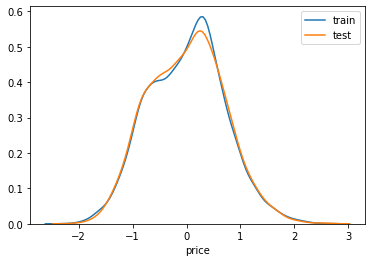

In [242]:
sns.distplot(y_train-y_pred_train, hist = False, label = 'train')
sns.distplot(y_test-y_pred_test, hist = False, label = 'test')

## Step 6: Utilize some different feature selection techniques before or in conjuction with fitting your models

### 6.1) Utilize a filter method to identify some features to remove from the model.  

In [243]:
## Code from Learn.co
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = stepwise_selection(predictors, data_fin['mpg'], verbose=True)
print('resulting features:')
print(result)

NameError: name 'predictors' is not defined

### 6.2) After removing the features, rerun steps 5 and see if you r new model performs better than the old model.

In [8]:
# your code here

## Step 7: Evaluate your different models in order to determine the best model overall

## Step 8:  Refit your best model to the entire dataset

## Step 9: Save your final model using pickle

https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/